# Exploratory data analysis and designing the grouping algorithm

In this notebook, we will run a compact EDA on the given dataset, and then test out different clustering algorithms in order to find a suitable one for the given task. The tested algorithms include:
* DBSCAN
* HDBSCAN
* OPTICS

#### Install and import packages

In [519]:
!pip3 install matplotlib
!pip3 install folium
!pip3 install scikit-learn
!pip3 install pandas
!pip3 install shapely
!pip3 install geopy
!pip3 install hdbscan

In [520]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS
import numpy as np
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
import uuid
import math
import folium
import time
import hdbscan


### Read data

Read the compressed CSV file and display the first few rows.

In [521]:
def read_data_and_extend(file_path):
    '''Read and display initial data'''
    df = pd.read_csv(file_path, compression='gzip')
    df['latitude_rad'] = np.radians(df['latitude'])
    df['longitude_rad'] = np.radians(df['longitude'])
    df['cluster_label'] = -1
    return df

df = read_data_and_extend('tours.csv.gz')
df_copy = df.copy()
df.head()

,user_id,latitude,longitude,latitude_rad,longitude_rad,cluster_label
0,0280088d,52.552575,13.443113,0.917215,0.234627,-1
1,0280088d,52.552958,13.442784,0.917222,0.234621,-1
2,a6468bc1,52.457977,12.843970,0.915564,0.224170,-1
3,0280088d,52.552796,13.441866,0.917219,0.234605,-1
4,49b2ce0a,52.486855,13.551305,0.916068,0.236515,-1


## Analysis

Perform basic data analysis and data visualization.

In [522]:
def basic_data_analysis(df):
    '''Perform basic data analysis'''
    print(f"Number of data points: {df.shape[0]}")
    print(f"Number of unique user_ids: {df['user_id'].nunique()}")
    print("Data types:\n", df.dtypes)
    print("Missing values:\n", df.isnull().sum())
    print("Summary statistics:\n", df.describe())

basic_data_analysis(df)

Number of data points: 19654
Number of unique user_ids: 9632
Data types:
 user_id           object
latitude         float64
longitude        float64
latitude_rad     float64
longitude_rad    float64
cluster_label      int64
dtype: object
Missing values:
 user_id          0
latitude         0
longitude        0
latitude_rad     0
longitude_rad    0
cluster_label    0
dtype: int64
Summary statistics:
            latitude     longitude  latitude_rad  longitude_rad  cluster_label
count  19654.000000  19654.000000  19654.000000   19654.000000        19654.0
mean      52.493997     13.369972      0.916193       0.233350           -1.0
std        0.097182      0.200209      0.001696       0.003494            0.0
min       52.186911     12.581296      0.910833       0.219585           -1.0
25%       52.432550     13.270148      0.915121       0.231608           -1.0
50%       52.499338     13.393642      0.916286       0.233763           -1.0
75%       52.546528     13.476121      0.917110    

#### Visualization

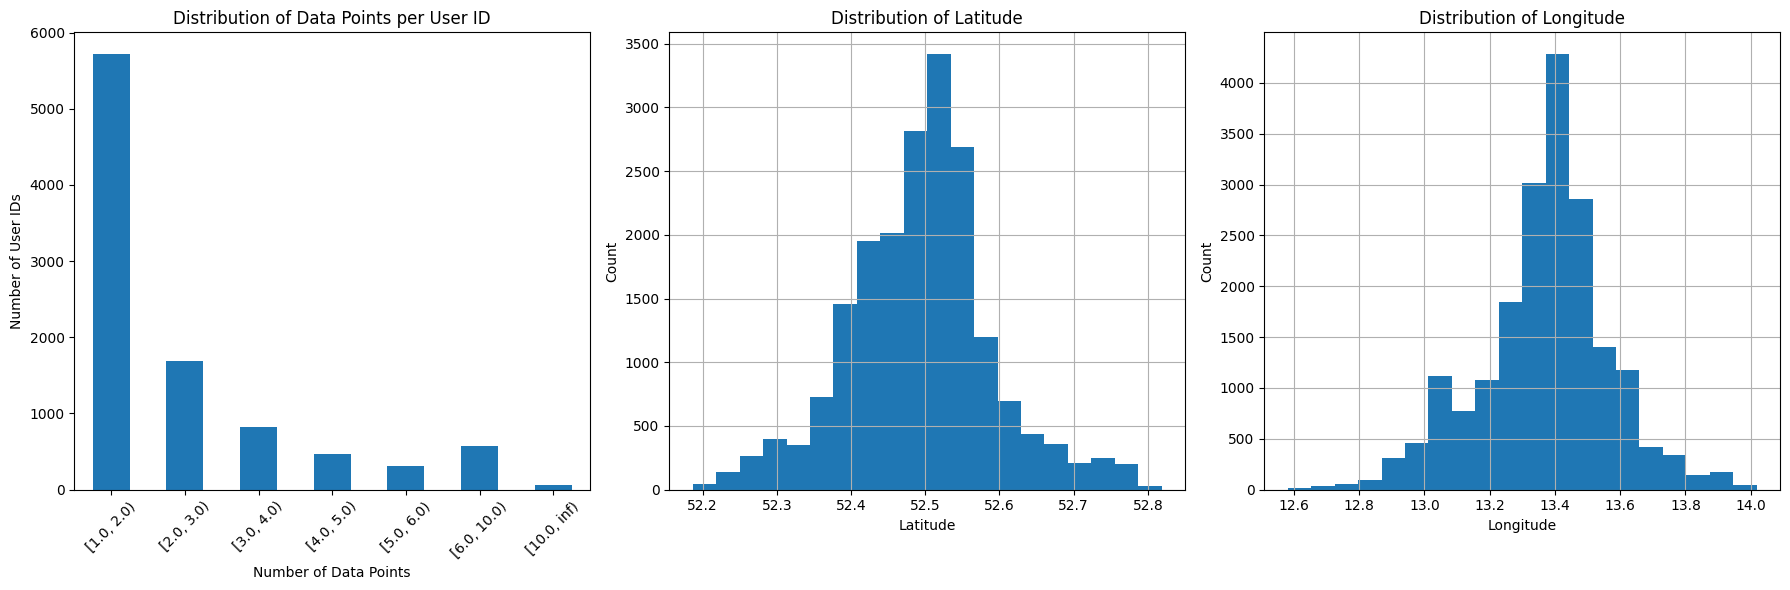

In [523]:
def plot_distribution(df):
    '''Plot distribution of data points and latitude/longitude histograms'''
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # plot distribution of data points
    data_points_per_user = df['user_id'].value_counts()
    data_points_counts = data_points_per_user.value_counts().sort_index()
    ranges = [1, 2, 3, 4, 5, 6, 10, float('inf')]
    grouped_counts = data_points_counts.groupby(pd.cut(data_points_counts.index, ranges, right=False)).sum()
    grouped_counts.plot(kind='bar', ax=axes[0])
    axes[0].set_xlabel('Number of Data Points')
    axes[0].set_ylabel('Number of User IDs')
    axes[0].set_title('Distribution of Data Points per User ID')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

    # plot latitude histogram
    df['latitude'].hist(bins=20, ax=axes[1])
    axes[1].set_xlabel('Latitude')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Latitude')

    # plot longitude histogram
    df['longitude'].hist(bins=20, ax=axes[2])
    axes[2].set_xlabel('Longitude')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Distribution of Longitude')
    
    plt.tight_layout()
    plt.show()

plot_distribution(df)

## Clustering

### DBSCAN

In [524]:
def dbscan_clustering(df, epsilon, min_samples):
    '''Perform DBSCAN clustering and add cluster labels to the DataFrame'''
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric="haversine")
    df['cluster_label'] = dbscan.fit_predict(df[['latitude_rad', 'longitude_rad']])
    return df, dbscan

In [525]:
df['latitude_rad'] = np.radians(df['latitude'])
df['longitude_rad'] = np.radians(df['longitude'])
kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian
min_samples = 5  # minimum number of samples in a cluster

df, dbscan = dbscan_clustering(df, epsilon, min_samples)

# Filter out remote ("noisy") points
df_filtered = df[df['cluster_label'] != -1]

# Create cluster groups
cluster_counts = df_filtered['cluster_label'].value_counts()
sorted_clusters = cluster_counts.sort_values(ascending=False)
sorted_clusters


cluster_label
0     17818
3        99
6        87
18       85
4        55
      ...  
67        5
12        5
77        5
45        5
78        5
Name: count, Length: 79, dtype: int64

In [526]:
def get_centermost_point(cluster):
    '''
    This function returns the center-most point from a cluster by taking a set of points (i.e., a cluster) 
    and returning the point within it that is nearest to some reference point (in this case, the cluster’s centroid):
    '''
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

cluster_labels = dbscan.labels_
num_clusters = len(set(cluster_labels))
coords = df[['latitude', 'longitude']].values

clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if len(coords[cluster_labels == n]) > 0]) 
centermost_points = clusters.map(get_centermost_point)
centermost_points

0       (52.49659886497629, 13.37248445759664)
1      (52.67175581715572, 13.164288006590008)
2       (52.55324380804789, 12.99411459500698)
3      (52.30389873734576, 13.254080503390972)
4       (52.59986880712316, 13.89600620397986)
                        ...                   
74     (52.46339768473499, 13.854190570090186)
75    (52.251242102806266, 12.957468742763496)
76      (52.50065310471778, 12.64648317097278)
77     (52.458194960948816, 12.86914763642015)
78     (52.20840818536819, 13.797767909119816)
Length: 79, dtype: object

In [527]:
def reassign_small_clusters(df, centermost_points, min_users=5):
    '''Assign the closest cluster for users in small clusters by finding the closest one from all the users points'''
    
    # Identify small clusters and valid (non-small) clusters
    cluster_sizes = df.groupby('cluster_label')['user_id'].nunique()
    small_clusters = cluster_sizes[cluster_sizes < min_users].index
    valid_clusters = cluster_sizes[cluster_sizes >= min_users].index
    print("Amount of small clusters:", len(small_clusters))
    
    # Filter centermost_points to include only valid clusters
    valid_centermost_points = centermost_points[centermost_points.index.isin(valid_clusters)]
    users_in_small_clusters = []
    for cluster in small_clusters:
        users_in_small_clusters.extend(df[df['cluster_label'] == cluster]['user_id'].unique())

    for user_id in users_in_small_clusters:
        user_coords = df.loc[df['user_id'] == user_id, ['latitude', 'longitude']].values
        closest_cluster = min(valid_centermost_points, key=lambda point: min(great_circle(point, coord).m for coord in user_coords))
        closest_cluster_idx = valid_centermost_points[valid_centermost_points == closest_cluster].index[0]
        df.loc[df['user_id'] == user_id, 'cluster_label'] = closest_cluster_idx
    return df


df = reassign_small_clusters(df, centermost_points)

Amount of small clusters: 31


In [528]:
def handle_outliers(df, centermost_points):
    '''Assign the closest cluster for users without a cluster by finding the closest one from all the users points'''
    users_without_cluster = []
    for user_id in df[df['cluster_label'] == -1]['user_id'].unique():
        if df[df['user_id'] == user_id]['cluster_label'].nunique() == 1:
            users_without_cluster.append(user_id)
    print(f"Users without a cluster: {len(users_without_cluster)}")

    for user_id in users_without_cluster:
        user_coords = df.loc[df['user_id'] == user_id, ['latitude', 'longitude']].values
        closest_cluster = min(centermost_points, key=lambda point: min(great_circle(point, coord).m for coord in user_coords))
        closest_cluster_idx = centermost_points[centermost_points == closest_cluster].index[0]
        df.loc[df['user_id'] == user_id, 'cluster_label'] = closest_cluster_idx
    return df

df = handle_outliers(df, centermost_points)

Users without a cluster: 362


In [529]:
def drop_and_filter(df, centermost_points):
    '''Drop outliers and keep only the rows with the smallest distance for each user_id'''
    # Drop the rows that have cluster_label -1. 
    df = df[df['cluster_label'] != -1]
    
    # Calculate distances for each row
    df['distance'] = df.apply(lambda row: great_circle(
        (row['latitude'], row['longitude']),
        centermost_points[row['cluster_label']]
    ).kilometers, axis=1)
    print(f"Shape of the DataFrame after dropping outliers: {df.shape}")
    
    # Get the indices of the rows with the smallest distance for each user_id
    min_distance_indices = df.groupby('user_id')['distance'].idxmin()
    
    # Filter the DataFrame to keep only the rows with the smallest distance for each user_id
    df = df.loc[min_distance_indices]
    print(f"Shape of the DataFrame after filtering: {df.shape}")
    
    return df

df = drop_and_filter(df, centermost_points)

Shape of the DataFrame after dropping outliers: (19352, 7)
Shape of the DataFrame after filtering: (9632, 7)


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


In [530]:
# Create a dictionary mapping cluster labels to starting point IDs and add starting points
start_point_ids = {index: uuid.uuid4() for index in centermost_points.index}

df['start_point_id'] = df['cluster_label'].map(start_point_ids)
df['start_point_latitude'] = df['cluster_label'].map(lambda x: centermost_points[x][0])
df['start_point_longitude'] = df['cluster_label'].map(lambda x: centermost_points[x][1])

df.head()

,user_id,latitude,longitude,latitude_rad,longitude_rad,cluster_label,distance,start_point_id,start_point_latitude,start_point_longitude
17218,0000571b,52.418764,13.808191,0.914880,0.240998,33,2.303971,57d9b511-8d3c-45dd-84a6-648d0b2f8362,52.410184,13.839112
8224,0001699f,52.555009,13.424564,0.917258,0.234303,0,7.389014,4b5aa672-125b-4ad7-9c25-e74799a91679,52.496599,13.372484
10627,00060476,52.484604,13.311919,0.916029,0.232337,0,4.312075,4b5aa672-125b-4ad7-9c25-e74799a91679,52.496599,13.372484
7164,0006963f,52.719423,13.259965,0.920128,0.231430,0,25.915692,4b5aa672-125b-4ad7-9c25-e74799a91679,52.496599,13.372484
17506,000e8618,52.470330,13.306235,0.915780,0.232238,0,5.353311,4b5aa672-125b-4ad7-9c25-e74799a91679,52.496599,13.372484


Generating groups within the clusters

In [531]:
def generate_groups(df, max_group_size):
    group_data = []
    unique_clusters = df['cluster_label'].unique().tolist()

    for cluster_label in unique_clusters:
        cluster_points = df[df['cluster_label'] == cluster_label]
        cluster_members = cluster_points['user_id'].tolist()
        unique_users = cluster_points['user_id'].nunique()
        num_groups = max(1, math.ceil(unique_users / max_group_size))
        group_size = math.ceil(unique_users / num_groups)
        for _ in range(num_groups):
            group_id = str(uuid.uuid4())
            members = []
            if unique_users >= group_size:
                members.extend(cluster_members[:group_size])
                cluster_members = cluster_members[group_size:] 
                unique_users -= group_size
            else:
                members.extend(cluster_members)
                cluster_members = []
                unique_users = 0
            group_data.append({'cluster_label': cluster_label, 'group_id': group_id, 'members': members, 'group_size': len(members)})

    df['group_id'] = None
    df['potential_group_members'] = None
    df['group_size'] = None
    for group in group_data:
        members = group['members']
        group_id = group['group_id']
        group_size = group['group_size']
        df.loc[df['user_id'].isin(members), 'group_id'] = group_id
        df.loc[df['user_id'].isin(members), 'potential_group_members'] = ','.join(members)
        df.loc[df['user_id'].isin(members), 'group_size'] = group_size

    return df

df = generate_groups(df, max_group_size=40)


In [532]:
def final_statistics(df):
    # Check that we didn't lose any users and that every user has a group appointed
    print("Number of users:", df.shape[0])
    print("Users without group:", df['group_id'].isna().sum())

    print(f"Total number of clusters: {df['cluster_label'].nunique()}")
    print(f"Total number of groups: {df['group_id'].nunique()}")

    # Calculate the average group size
    group_sizes = df.groupby('group_id')['group_size'].first()
    average_group_size = round(group_sizes.mean(), 2)
    print(f"Average group size: {average_group_size}")

    # Check statistics of mean, median, and max distance
    mean_distance = round(df['distance'].mean(), 2)
    print("Mean distance among all users:", mean_distance)
    median_distance = round(np.median(df['distance']), 2)
    print("Median distance:", median_distance)
    max_distance = round(df['distance'].max(), 2)
    print("Max distance:", max_distance)

    smallest_cluster_count = df['cluster_label'].value_counts().min()
    print("Amount of users in the smallest cluster:", smallest_cluster_count)
    smallest_group_count = df['group_id'].value_counts().min()
    print("Amount of users in the smallest group:", smallest_group_count)

final_statistics(df)


Number of users: 9632
Users without group: 0
Total number of clusters: 79
Total number of groups: 297
Average group size: 32.43
Mean distance among all users: 10.64
Median distance: 7.85
Max distance: 36.05
Amount of users in the smallest cluster: 1
Amount of users in the smallest group: 1


### Resulting cluster visualization

In [533]:
# Create a folium map centered around the mean latitude and longitude
map_center = [df['start_point_latitude'].mean(), df['start_point_longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add markers for each cluster center
for cluster_center in centermost_points:
    folium.Marker(location=cluster_center).add_to(m)
# Display the map
m

## Improvements and hyperparameter optimization

 Perform hyperparameter optimization using looped search in order to find the more optimal values for epsilon. This could be performed also through GridSearch using mean distance as a metric.

 Additionally, the code is extended to be able to handle multiple dbscans in a loop.

In [534]:
def perform_clustering(df, eps_values):
    '''Perform multiple rounds of DBSCAN clustering with different epsilon values'''
    kms_per_radian = 6371.0088
    min_samples = 5  # minimum number of samples in a cluster
    # Initialize label offset
    label_offset = -1

    for _, eps in enumerate(eps_values):
        # Filter out data points that have not been assigned to a cluster
        df_to_cluster = df[df['cluster_label'] == -1]
        if df_to_cluster.empty:
            break

        df_to_cluster, _ = dbscan_clustering(df_to_cluster, eps/kms_per_radian, min_samples)

        # Adjust labels for the new clusters
        df_to_cluster.loc[df_to_cluster['cluster_label'] != -1, 'cluster_label'] += label_offset + 1

        # Update the label offset (to avoid mixing the same cluster label in different iterations)
        label_offset = df_to_cluster['cluster_label'].max()

        # Update labels in the original DataFrame
        df.loc[df_to_cluster.index, 'cluster_label'] = df_to_cluster['cluster_label']
    print(f"Number of clusters: {df['cluster_label'].nunique()}")
    return df

In [535]:
eps_value_search =  [[0.5], [1], [3], [0.5,1,3, 10]]

for eps_values in eps_value_search:
    start_time = time.time()
    df = read_data_and_extend('tours.csv.gz')
    print("Current epsilon values:", eps_values)
    
    df = perform_clustering(df, eps_values)

    # Get the centermost point for each cluster
    cluster_labels = df['cluster_label']
    num_clusters = len(set(cluster_labels))
    coords = df[['latitude', 'longitude']].values
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if len(coords[cluster_labels == n]) > 0]) 
    centermost_points = clusters.map(get_centermost_point)

    df = handle_outliers(df, centermost_points)
    df = drop_and_filter(df, centermost_points)
    df = reassign_small_clusters(df, centermost_points)
    df = generate_groups(df, max_group_size=40)
    
    final_statistics(df)
    end_time = time.time()
    elapsed_time = round(end_time - start_time,2)
    print(f"Elapsed time for eps_values {eps_values}: {elapsed_time} seconds")
    print("***"*20)


Current epsilon values: [0.5]
Number of clusters: 277
Users without a cluster: 1268


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (18673, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 30
Number of users: 9632
Users without group: 0
Total number of clusters: 246
Total number of groups: 410
Average group size: 23.49
Mean distance among all users: 4.25
Median distance: 3.22
Max distance: 17.1
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for eps_values [0.5]: 7.67 seconds
************************************************************
Current epsilon values: [1]
Number of clusters: 80
Users without a cluster: 362


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (19342, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 8
Number of users: 9632
Users without group: 0
Total number of clusters: 71
Total number of groups: 288
Average group size: 33.44
Mean distance among all users: 10.59
Median distance: 7.84
Max distance: 36.05
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for eps_values [1]: 2.47 seconds
************************************************************
Current epsilon values: [3]
Number of clusters: 10
Users without a cluster: 29


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (19631, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 0
Number of users: 9632
Users without group: 0
Total number of clusters: 9
Total number of groups: 247
Average group size: 39.0
Mean distance among all users: 13.11
Median distance: 9.89
Max distance: 51.57
Amount of users in the smallest cluster: 6
Amount of users in the smallest group: 6
Elapsed time for eps_values [3]: 1.7 seconds
************************************************************
Current epsilon values: [0.5, 1, 3, 10]


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/2817395033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = dbscan.fit_predict(df[['latitude_rad', 'longitude_rad']])
/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/2817395033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = dbscan.fit_predict(df[['latitude_rad', 'longitude_rad']])
/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/2817395033.py:4: SettingWithCop

Number of clusters: 443
Users without a cluster: 7


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (19649, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 197
Number of users: 9632
Users without group: 0
Total number of clusters: 245
Total number of groups: 410
Average group size: 23.49
Mean distance among all users: 4.6
Median distance: 3.23
Max distance: 41.86
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 3
Elapsed time for eps_values [0.5, 1, 3, 10]: 2.73 seconds
************************************************************


## Alternatives clustering models

Next, we will check the performance of alternative clustering methods, namely HDBSCAN and OPTICS.

### HDBSCAN

In [536]:
def hdbscan_clustering(df, min_cluster_size=5):
    '''Perform HDBSCAN clustering and add cluster labels to the DataFrame'''
    hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='haversine')
    df['cluster_label'] = hdbscan_cluster.fit_predict(df[['latitude_rad', 'longitude_rad']])
    return df, hdbscan_cluster

In [537]:
min_cluster_sizes = [5, 10, 20]

for min_cluster_size in min_cluster_sizes:
    start_time = time.time()
    print("Min cluster size:", min_cluster_size)
    df = read_data_and_extend('tours.csv.gz')

    df, _ = hdbscan_clustering(df, min_cluster_size)
    cluster_labels = df['cluster_label']
    num_clusters = len(set(cluster_labels))
    coords = df[['latitude', 'longitude']].values
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if len(coords[cluster_labels == n]) > 0]) 
    centermost_points = clusters.map(get_centermost_point)

    df = handle_outliers(df, centermost_points)
    df = drop_and_filter(df, centermost_points)
    df = reassign_small_clusters(df, centermost_points, min_cluster_size)
    df = generate_groups(df, max_group_size=40)

    final_statistics(df)
    end_time = time.time()
    elapsed_time = round(end_time - start_time,2)
    print(f"Elapsed time for min cluster size {min_cluster_size}: {elapsed_time} seconds")
    print("*"*20)

Min cluster size: 5
Users without a cluster: 3731


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (16622, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 111
Number of users: 9632
Users without group: 0
Total number of clusters: 913
Total number of groups: 916
Average group size: 10.52
Mean distance among all users: 0.55
Median distance: 0.31
Max distance: 13.78
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for min cluster size 5: 41.72 seconds
********************
Min cluster size: 10
Users without a cluster: 4739


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (16150, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 4
Number of users: 9632
Users without group: 0
Total number of clusters: 346
Total number of groups: 393
Average group size: 24.51
Mean distance among all users: 1.0
Median distance: 0.62
Max distance: 18.26
Amount of users in the smallest cluster: 10
Amount of users in the smallest group: 10
Elapsed time for min cluster size 10: 27.33 seconds
********************
Min cluster size: 20
Users without a cluster: 681


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (19062, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 0
Number of users: 9632
Users without group: 0
Total number of clusters: 11
Total number of groups: 247
Average group size: 39.0
Mean distance among all users: 10.23
Median distance: 7.99
Max distance: 38.06
Amount of users in the smallest cluster: 60
Amount of users in the smallest group: 15
Elapsed time for min cluster size 20: 4.46 seconds
********************


### OPTICS

In [538]:
def optics_clustering(df, min_samples, xi, metric='haversine'):
    '''Perform OPTICS clustering and add cluster labels to the DataFrame'''
    optics = OPTICS(min_samples=min_samples, xi=xi, metric=metric)
    df['cluster_label'] = optics.fit_predict(df[['latitude_rad', 'longitude_rad']])
    return df, optics


min_cluster_sizes = [5, 10, 20]

for min_cluster_size in min_cluster_sizes:
    start_time = time.time()
    print("Min cluster size:", min_cluster_size)
    df = read_data_and_extend('tours.csv.gz')

    df, _ = optics_clustering(df, min_cluster_size, xi=0.05)
    cluster_labels = df['cluster_label']
    num_clusters = len(set(cluster_labels))
    coords = df[['latitude', 'longitude']].values
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if len(coords[cluster_labels == n]) > 0]) 
    centermost_points = clusters.map(get_centermost_point)

    df = handle_outliers(df, centermost_points)
    df = drop_and_filter(df, centermost_points)
    df = reassign_small_clusters(df, centermost_points, min_cluster_size)
    df = generate_groups(df, max_group_size=40)

    final_statistics(df)
    end_time = time.time()
    elapsed_time = round(end_time - start_time,2)
    print(f"Elapsed time for min cluster size {min_cluster_size}: {elapsed_time} seconds")
    print("*"*20)

Min cluster size: 5
Users without a cluster: 3454


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (16803, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 399
Number of users: 9632
Users without group: 0
Total number of clusters: 1081
Total number of groups: 1081
Average group size: 8.91
Mean distance among all users: 0.42
Median distance: 0.24
Max distance: 13.57
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for min cluster size 5: 65.15 seconds
********************
Min cluster size: 10
Users without a cluster: 5070


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (16371, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 32
Number of users: 9632
Users without group: 0
Total number of clusters: 493
Total number of groups: 497
Average group size: 19.38
Mean distance among all users: 0.76
Median distance: 0.47
Max distance: 14.26
Amount of users in the smallest cluster: 10
Amount of users in the smallest group: 10
Elapsed time for min cluster size 10: 47.19 seconds
********************
Min cluster size: 20
Users without a cluster: 6936


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (16845, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 1
Number of users: 9632
Users without group: 0
Total number of clusters: 145
Total number of groups: 316
Average group size: 30.48
Mean distance among all users: 1.56
Median distance: 1.02
Max distance: 20.88
Amount of users in the smallest cluster: 20
Amount of users in the smallest group: 20
Elapsed time for min cluster size 20: 40.21 seconds
********************


Since OPTICS looks like being able to perform the best, lets test a couple different xi values for the sake of curiosity to try and improve the results further with a small effort.

In [539]:
from sklearn.cluster import OPTICS
def optics_clustering(df, min_samples, xi, metric='haversine'):
    '''Perform OPTICS clustering and add cluster labels to the DataFrame'''
    optics = OPTICS(min_samples=min_samples, xi=xi, metric=metric)
    df['cluster_label'] = optics.fit_predict(df[['latitude_rad', 'longitude_rad']])
    return df, optics


min_cluster_size = 5
xis = [0.01, 0.05, 0.1, 0.2, 0.5]

for xi in xis:
    start_time = time.time()
    print("Xi:", xi)
    df = read_data_and_extend('tours.csv.gz')

    df, _ = optics_clustering(df, min_cluster_size, xi)
    cluster_labels = df['cluster_label']
    num_clusters = len(set(cluster_labels))
    coords = df[['latitude', 'longitude']].values
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if len(coords[cluster_labels == n]) > 0]) 
    centermost_points = clusters.map(get_centermost_point)

    df = handle_outliers(df, centermost_points)
    df = drop_and_filter(df, centermost_points)
    df = reassign_small_clusters(df, centermost_points, min_cluster_size)
    df = generate_groups(df, max_group_size=40)

    final_statistics(df)
    end_time = time.time()
    elapsed_time = round(end_time - start_time,2)
    print(f"Elapsed time for min cluster size {min_cluster_size}: {elapsed_time} seconds")
    print("*"*20)

Xi: 0.01
Users without a cluster: 2951


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (17100, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 476
Number of users: 9632
Users without group: 0
Total number of clusters: 1086
Total number of groups: 1086
Average group size: 8.87
Mean distance among all users: 0.4
Median distance: 0.22
Max distance: 13.57
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for min cluster size 5: 61.23 seconds
********************
Xi: 0.05
Users without a cluster: 3454


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (16803, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 399
Number of users: 9632
Users without group: 0
Total number of clusters: 1081
Total number of groups: 1081
Average group size: 8.91
Mean distance among all users: 0.42
Median distance: 0.24
Max distance: 13.57
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for min cluster size 5: 63.48 seconds
********************
Xi: 0.1
Users without a cluster: 4433


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (16514, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 283
Number of users: 9632
Users without group: 0
Total number of clusters: 1032
Total number of groups: 1032
Average group size: 9.33
Mean distance among all users: 0.46
Median distance: 0.27
Max distance: 13.63
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for min cluster size 5: 70.33 seconds
********************
Xi: 0.2
Users without a cluster: 6299


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (16670, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 108
Number of users: 9632
Users without group: 0
Total number of clusters: 856
Total number of groups: 857
Average group size: 11.24
Mean distance among all users: 0.6
Median distance: 0.36
Max distance: 14.32
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for min cluster size 5: 77.66 seconds
********************
Xi: 0.5
Users without a cluster: 8928


/var/folders/6s/2x10_fcj5r5bzst764c833zw0000gn/T/ipykernel_79514/892840870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(lambda row: great_circle(


Shape of the DataFrame after dropping outliers: (18811, 7)
Shape of the DataFrame after filtering: (9632, 7)
Amount of small clusters: 5
Number of users: 9632
Users without group: 0
Total number of clusters: 364
Total number of groups: 433
Average group size: 22.24
Mean distance among all users: 1.16
Median distance: 0.76
Max distance: 17.68
Amount of users in the smallest cluster: 5
Amount of users in the smallest group: 5
Elapsed time for min cluster size 5: 65.73 seconds
********************


## Conclusions

In this notebook, we found out that with the given dataset and the tested configuration and grouping logic, OPTICS was the best performing while DBSCAN was the weakest in regard of mean distance to the starting point. On the other hand, the increase in computation time was also significant, growing from DBSCANs 2 seconds to OPTICS around 1 minute. This should be taken into account if the test dataset doesn't represent reality, and the script would be used on larger datasets. 

A minimum group size of 5 was chosen, but this is more of a business decision than computational one, and could be easily changed. The resulting group sizes for most outputs were between 9 and 39, which sounds reasonable to the writer.


For DBSCAN, with around 500m radius, we resulted in a mean and median distances of 4 and 3 kilometers, while the maximum distance a user would have to experience with this grouping is 17km.

For HDBSCAN, the values are:
- Mean distance among all users: 0.55
- Median distance: 0.31
- Max distance: 13.78

And for OPTICS, using min_cluster_size = 5 and xi = 0.01:
- Mean distance among all users: 0.4
- Median distance: 0.22
- Max distance: 13.57